# Traffic Sign Classifier using Tensorflow V1

For this demo we will train and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained, we will then try out the model on the German traffic signs test images.

[Here](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) is a published baseline model and inspiration for solving the traffic sign problem.

**NOTE:** To try your own dataset feel free to change input directory in the 'Load The Data' section.

---

## Import Modules

In [1]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.utils import shuffle
import pandas as pd
from imutils import paths
import tensorflow as tf
if tf.__version__.split('.')[0] is '2':
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


## Load The Data
### Training and Validation
The dataset obtained has been resized to 32x32 and stored as pickle files. These dataset files have been placed in a folder called `dataset/German_Traffic_Sign_Dataset`.

<b> Due to the size of the training and validation files they are not included. You will need to download these files by running the following cell.</b>

If you do not have `wget` you can download the data from [HERE](https://www.dropbox.com/sh/1b3igfktndbft0b/AAAUdxR9VDFfBswr-EPsYWXza?dl=0) and then placed them in the folder mentioned above. If none of it works then you can download the [original dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) and follow the instructions from their website. 

In [2]:
%%capture
# %%capture is used to ignore output when content is boring.      
!wget -O ./dataset/German_Traffic_Sign_Dataset/valid.p "https://www.dropbox.com/s/qgfouq8zhmhamcq/valid.p?dl=1"
!wget -O ./dataset/German_Traffic_Sign_Dataset/train.p "https://www.dropbox.com/s/vrwdcqmuaefpzox/train.p?dl=1"

Each pickle file contains a dictionary with 4 key/value pairs:

- **features** is a 4D array containing raw pixel data of the traffic sign images, (sample number, width, height, channels).
- **labels** is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- **sizes** is a list containing tuples, (width, height) representing the original width and height of the image.
- **coords** is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [3]:
# Fill this in based on where you saved the training, validation
training_file   = "./dataset/German_Traffic_Sign_Dataset/train.p"
validation_file = "./dataset/German_Traffic_Sign_Dataset/valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

### Testing
There are two test files:
- One test file follows the same rules as validation and training and can be downloaded with the following cell.
- The other is a collection of images obatined from the web and they all come in different sizes. These are under `dataset/German_Traffic_Sign_Dataset/my_test_images`.

In [4]:
%%capture
!wget -O ./dataset/German_Traffic_Sign_Dataset/test.p  "https://www.dropbox.com/s/bqyl6ncwtlq9f7m/test.p?dl=1"

In [5]:
test_file = "./dataset/German_Traffic_Sign_Dataset/test.p"
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_test, y_test = test['features'], test['labels']

 <b>IF YOU WANT TO TRY YOUR OWN GERMAN TRAFFIC SIGNS ADD THEM IN </b> `dataset/German_Traffic_Sign_Dataset/my_test_images`. And update the label list `y_my_test` in the following cell. You may find `signnames.csv` useful for labeling the image as it contains mappings from the class id (integer) to the actual sign name.

In [6]:
# My Test Images
test_dir = "./dataset/German_Traffic_Sign_Dataset/my_test_images"
test_images = sorted([file for file in os.listdir(test_dir) if file.startswith('test')]) # prevents .ipynb_checkpoints,etc from being listed
 
# Read in RGB format and resize,
# then convert to numpy array
X_my_test = []
for test_image in test_images:
    imagePath = os.path.join(test_dir, test_image)
    X_my_test.append(cv2.resize(mpimg.imread(imagePath), dsize=(32, 32), interpolation=cv2.INTER_CUBIC))

X_my_test = np.array(X_my_test)
y_my_test = np.array([1,4,28,36,40,14], dtype=np.uint8)

---

## Visualize and Explore Dataset

#### General Info
There are multiple classes labeled as an id number in this dataset. The file `signnames.csv` contains id to name mappings for each id.


In [7]:
n_train = len(y_train)              # Number of training examples
n_validation = len(y_valid)         # Number of validation examples
n_test = len(y_test)                # Number of test examples.
n_my_test = len(y_my_test)          # Number of "my" test examples.
n_classes = len(np.unique(y_train)) # Number of classes in data set

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))
assert(len(X_my_test) == len(y_my_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print("My Test Set:    {} samples".format(n_my_test))
print()
print("Number of classes = ", n_classes)
print("The class labels are: \n", np.unique(y_train))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples
My Test Set:    6 samples

Number of classes =  43
The class labels are: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


#### Dataset Labels

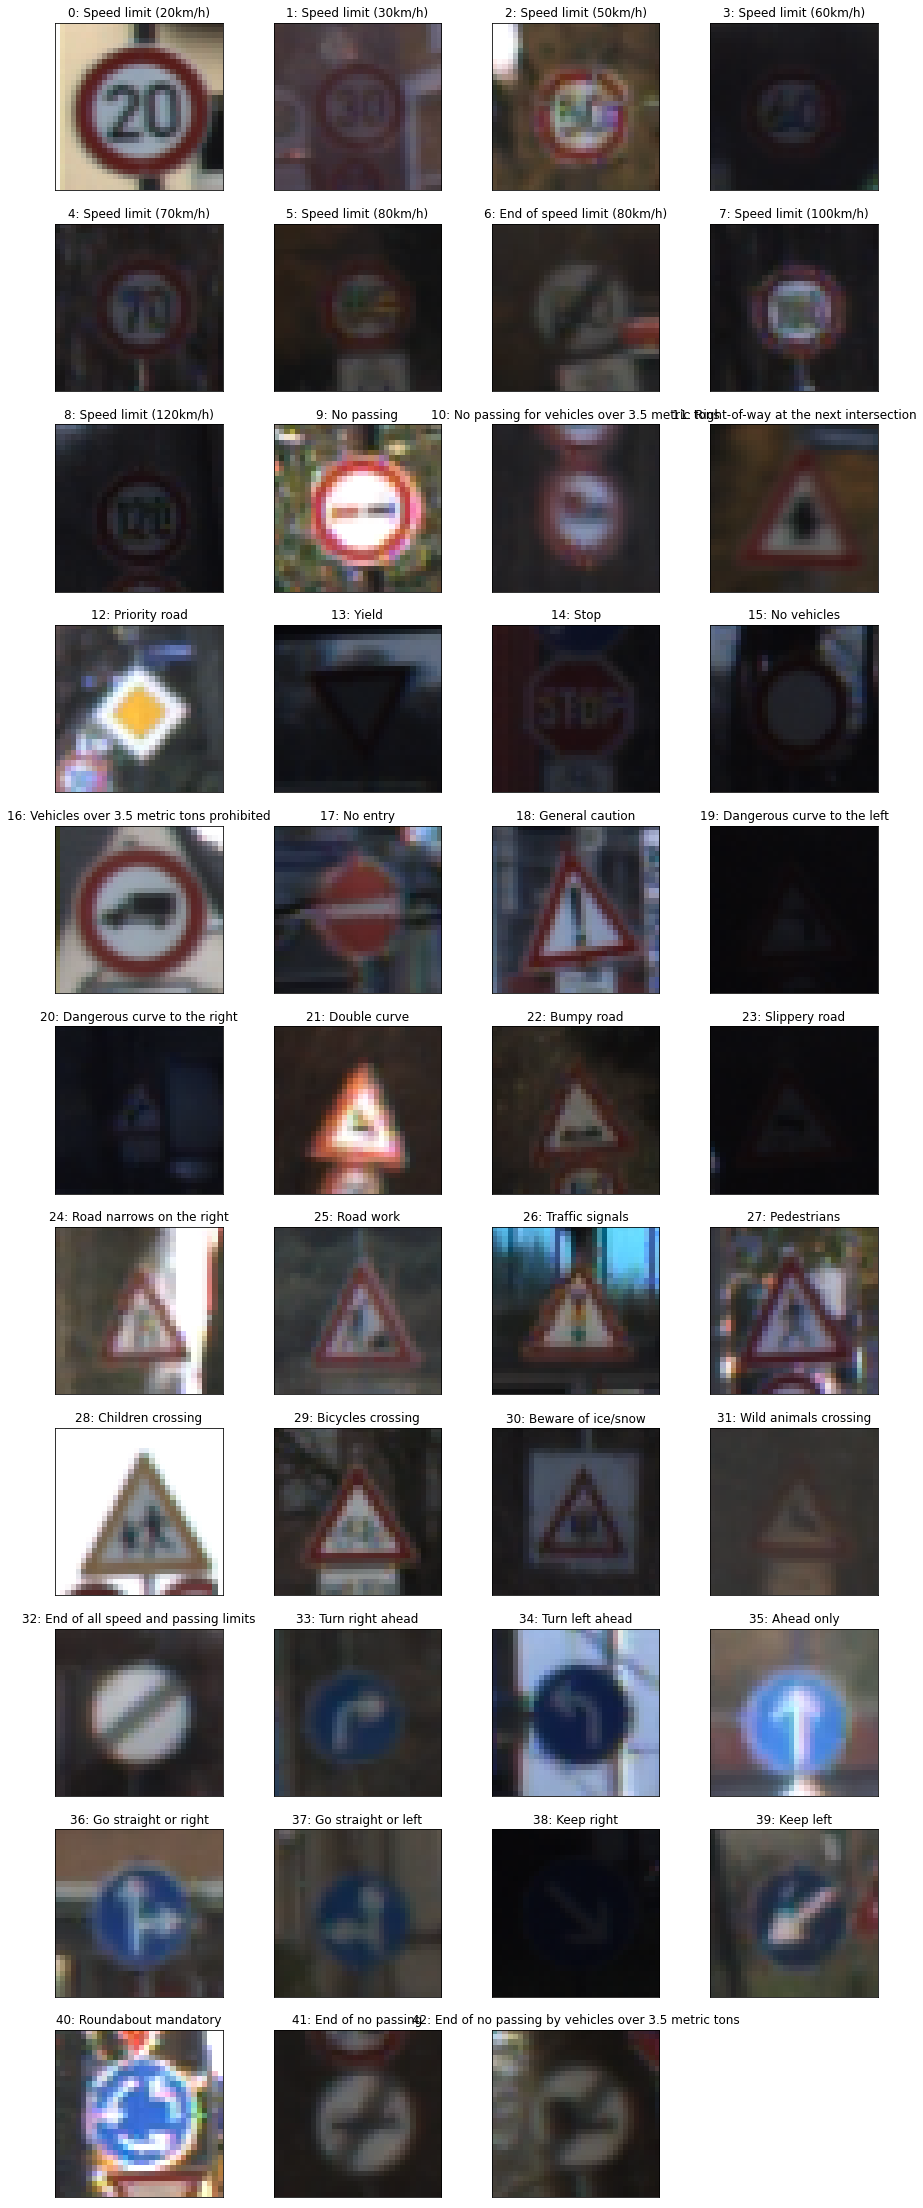

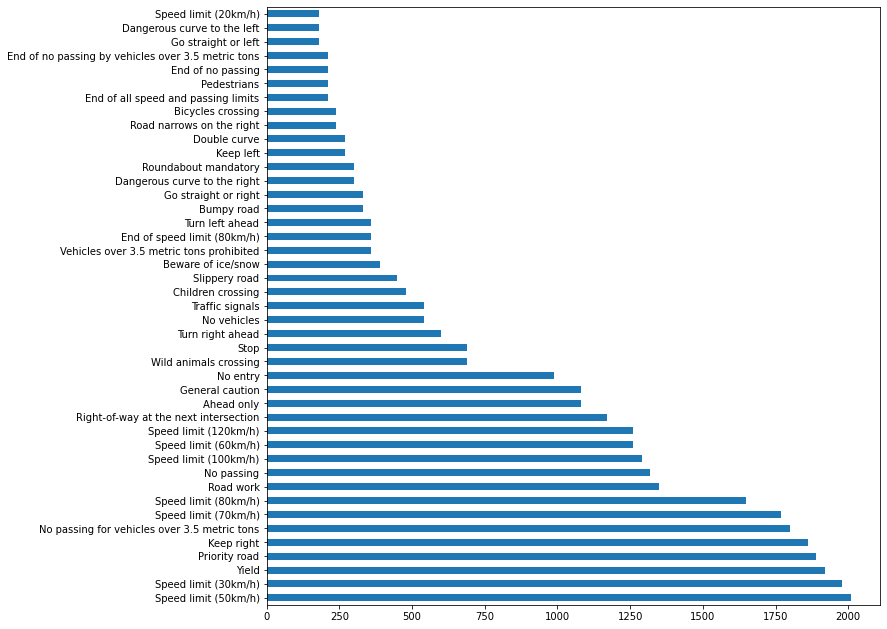

In [8]:
# Label Names
df = pd.read_csv('./dataset/German_Traffic_Sign_Dataset/signnames.csv', sep=',')
label_names = np.array(df['SignName']) 

# Create Catalog
plt.figure(1,figsize=(15, 40))        #inches width and height
for i in range(n_classes):    
    plt.subplot(11,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(i) + ": " + str(label_names[i]))
    idx = np.nonzero([y_train == i])[1][0] # second element contains array of indeces, then Choose first element from selected indeces
    plt.imshow(X_train[idx])

# Create distribution
plt.figure(2,figsize=(12, 12))
df = pd.DataFrame(label_names[y_train], columns=['train_labels'])
df_train_labels = df['train_labels']
df_train_labels.value_counts().plot(kind='barh', figsize=(11, 11))

The distribution of classes in the training set is not even; there are more examples of some classes than others. This raises the question: do we need to generate fake data to make the distribution even? 

---
## Pre-process the Dataset

In [9]:
def preprocess(X, using_type=3):
    """ 
    Preprocess assumes X is of shape [numOfImages, height, width, channels]. 
    Set type number to specify the type of normalization you desire:
        Type 1: Quick way to approximately normalize the data (pixel - 128)/ 128.
        Type 2: Classic normalization based on training set.
        Type 3: ImageNet normalization
    """
    if (using_type == 1):
        return (X - 128)/ 128
    elif (using_type == 2):
        return (X - np.mean(X_train))/ np.std(X_train)
    elif (using_type == 3):
        RGB_mean = [0.485, 0.456, 0.406]
        RGB_std = [0.229, 0.224, 0.225]
        X = X/255.0
        X[:, 0, :, :] -= RGB_mean[0]
        X[:, 1, :, :] -= RGB_mean[1]
        X[:, 2, :, :] -= RGB_mean[2]
        X[:, 0, :, :] /= RGB_std[0]
        X[:, 1, :, :] /= RGB_std[1]
        X[:, 2, :, :] /= RGB_std[2]
        return X
        
        
# Scaled by normalization 
Xs_train   = preprocess(X_train)
Xs_valid   = preprocess(X_valid)
Xs_test    = preprocess(X_test)
Xs_my_test = preprocess(X_my_test)

---
## Model Architecture

#### Network Parameters

In [10]:
EPOCHS     = 10
BATCH_SIZE = 128
dropout    = 0.75         # Dropout, probability to keep units in fully connected layers
learning_rate = 0.001

#### Weights and Biases for Net

In [11]:
# Define layers weight & bias
# wc: convolutional weights  -> [height, width, input_depth, output_depth]
# wd: dropout fc weights     -> [input_depth, output_depth]
# bc, bd: conv and fc biases -> [output_depth]

# Arguments used for tf.truncated_normal
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.random.normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.random.normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.random.normal([5*5*16, 120], mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.random.normal([120, 84], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.random.normal([84, n_classes], mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([6])),
    'bc2': tf.Variable(tf.zeros([16])),
    'bd1': tf.Variable(tf.zeros([120])),
    'bd2': tf.Variable(tf.zeros([84])),
    'out': tf.Variable(tf.zeros([n_classes]))}

#### Helper functions for Net

In [12]:
def conv2d(x, W, b, strides=1, name=None):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x, name=name)

def maxpool2d(x, k=2, name=None):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1], # [batch, height, width, depth]
        padding='SAME',
        name=name)
    

#### Net Classifier

In [13]:
def LeNet(x, weights, biases, keep):    
    
    # Layer 1: Convolutional-> Input = 32x32x3. Output = 28x28x6. Activation Relu. Pooling-> Input = 28x28x6. Output = 14x14x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], name="conv1")
    conv1 = maxpool2d(conv1, k=2, name="conv1_max")
    #print(conv1.get_shape())
    
    # Layer 2: Convolutional-> Output = 10x10x16. Activation Relu. Pooling-> Input = 10x10x16. Output = 5x5x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], name="conv2")
    conv2 = maxpool2d(conv2, k=2, name="conv2_max")
    #print(conv2.get_shape())

    # Layer 3: Flatten-> Input = 5x5x16 = Output = 400. Fully Connected-> Input = 400. Output = 120. Activation.
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84. Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return out

## Pipeline

#### Placeholders
`x` is a placeholder for a batch of input images: features.

`y` is a placeholder for a batch of output labels.

`keep_prob` is a placeholder for specifying the probability of nodes to keep when performing dropout in fully connected layers.

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

#### Training

In [15]:
logits = LeNet(x, weights, biases,  keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




#### Model Evaluation: Training, Validation, and Testing
Evaluate how well the loss and accuracy of the model for a given dataset per batch size. Set `keep_prob`to 1 to use all fc nodes during evaluation.

**Recall:** A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
# Note: the 1 in argmax means to search in two dimensions 
correct_prediction = tf.equal(tf.argmax(logits, 1) , tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#LOSS and ACCURACY
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
        loss = sess.run(loss_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.0})
     
    acc_per_epoch = total_accuracy / num_examples
    loss_of_last_batch = loss 
    return (acc_per_epoch, loss_of_last_batch)

---
## Run Session: Train the Model
- Run the training data through the training pipeline to train the model.

- Before each epoch, shuffle the training set.

- After each epoch, measure the loss and accuracy of the validation set.

- Save the model after training.

In [17]:
# Set up to save Model's weights
saver = tf.train.Saver()
save_file_path = './net_weights/lenet.ckpt'
#save_file_path = './lenet'

In [18]:
# Train and Evaluate
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        Xs_train, y_train = shuffle(Xs_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = Xs_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})
        
        validation_accuracy, validation_loss = evaluate(Xs_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, save_file_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.691
Validation Loss = 1.283

EPOCH 2 ...
Validation Accuracy = 0.841
Validation Loss = 0.431

EPOCH 3 ...
Validation Accuracy = 0.874
Validation Loss = 0.212

EPOCH 4 ...
Validation Accuracy = 0.904
Validation Loss = 0.214

EPOCH 5 ...
Validation Accuracy = 0.919
Validation Loss = 0.255

EPOCH 6 ...
Validation Accuracy = 0.941
Validation Loss = 0.119

EPOCH 7 ...
Validation Accuracy = 0.934
Validation Loss = 0.159

EPOCH 8 ...
Validation Accuracy = 0.936
Validation Loss = 0.158

EPOCH 9 ...
Validation Accuracy = 0.946
Validation Loss = 0.060

EPOCH 10 ...
Validation Accuracy = 0.949
Validation Loss = 0.052

Model saved


---

## Test The Model 

Use your trained model to predict the traffic sign type on both collections of test images.

#### Choose & Visualize My Test Images

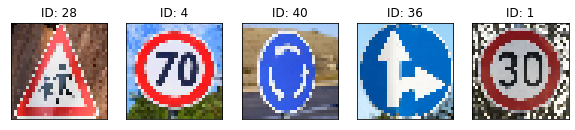

In [19]:
# Load 5 images from the test set and plot them here.
idx = random.sample(range(len(X_my_test)), 5)

plt.figure(figsize=(10, 2))        #inches width and height
for i in range(len(idx)):    
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("ID: " + str(y_my_test[idx[i]]))
    plt.imshow(X_my_test[idx[i]])

#### Predict the Sign Type for My Test Images

In [20]:
# Remove the previous weights and biases
#tf.reset_default_graph()

# Restore saved weights and test new images to obtain prediction y_hat
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    #saver.restore(sess, save_file_path)
    
    test_y_hat = sess.run(tf.argmax(logits, 1), feed_dict={
                        x: Xs_my_test[idx],
                        y: y_my_test[idx],
                        keep_prob: 1.0})
        
    print('Test Predicted Outputs: {}'.format(test_y_hat))


INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt
Test Predicted Outputs: [28  4 40 18  1]


#### Analyze and Compare Accuracy Performance of both Test Set

In [35]:
# Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    my_test_accuracy = sess.run(accuracy_operation, feed_dict={
                        x: Xs_my_test[idx],
                        y: y_my_test[idx],
                        keep_prob: 1.0})
    
    print('Test Accuracy: {} %'.format(my_test_accuracy*len(Xs_my_test)))

INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt
Test Accuracy: 4.800000071525574 %


In [34]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    validation_accuracy, validation_loss = evaluate(Xs_my_test, y_my_test)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Validation Loss = {:.3f}".format(validation_loss))

INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt
Validation Accuracy = 0.667
Validation Loss = 5.836


In [ ]:
find out what accuracy does and wether it should be my_test_accuracy*len(Xs_my_test))) or len of set

In [36]:
# Calculate the accuracy for the original test dataset
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    test_accuracy = sess.run(accuracy_operation, feed_dict={
                        x: Xs_test,
                        y: y_test,
                        keep_prob: 1.0})
    
    print('Test Accuracy: {} %'.format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt
Test Accuracy: 91.73396825790405 %


---
## Inspection Analysis of Model

#### Output Top 5 Softmax Probabilities For My Test Images

We will make use of [`tf.nn.top_k`](https://www.tensorflow.org/api_docs/python/tf/math/top_k) 
to print out the model's top 5 softmax probabilities for each test image. 

In general, `tf.nn.top_k` returns the top_k values per row. Therefore, it returns a matrix where every row represents an image and there are top_k columns. It also returns another matrix of similar dimensions with the indeces of those top_k values. 

In [23]:
# Print out the top five softmax probabilities for each test prediction.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    test_all_softmax_prob = tf.nn.softmax(logits)
    test_top5_softmax_prob_operation = tf.nn.top_k(test_all_softmax_prob, k=5)
    
    test_top5_softmax_prob = sess.run(test_top5_softmax_prob_operation, feed_dict={
                                x: Xs_my_test[idx],
                                y: y_my_test[idx],
                                keep_prob: 1.0})
    
    # Display results
    for i in range(test_top5_softmax_prob[0].shape[0]):      # for every image
        print('For image X_test[{}] -> "{}" The top 5 softmax results:'.format(str(idx[i]) , label_names[y_my_test[idx[i]]] ) )
        for j in range(test_top5_softmax_prob[0].shape[1]):  # for each top value
            print('\t {}%   : {} '.format(round(test_top5_softmax_prob[0][i][j]*100,2), label_names[test_top5_softmax_prob[1][i][j]]))
        print()    

INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt
For image X_test[2] -> "Children crossing" The top 5 softmax results:
	 99.79%   : Children crossing 
	 0.11%   : Pedestrians 
	 0.08%   : Road narrows on the right 
	 0.01%   : Bicycles crossing 
	 0.0%   : Dangerous curve to the right 

For image X_test[1] -> "Speed limit (70km/h)" The top 5 softmax results:
	 99.9%   : Speed limit (70km/h) 
	 0.1%   : Speed limit (120km/h) 
	 0.0%   : Speed limit (20km/h) 
	 0.0%   : Speed limit (30km/h) 
	 0.0%   : No vehicles 

For image X_test[4] -> "Roundabout mandatory" The top 5 softmax results:
	 99.93%   : Roundabout mandatory 
	 0.07%   : Keep right 
	 0.0%   : Keep left 
	 0.0%   : Turn left ahead 
	 0.0%   : Go straight or left 

For image X_test[3] -> "Go straight or right" The top 5 softmax results:
	 99.98%   : General caution 
	 0.02%   : Keep right 
	 0.0%   : Traffic signals 
	 0.0%   : Go straight or right 
	 0.0%   : End of all speed and passing limits 

For image 

#### Visualize the Neural Network's State for one of My Test Images

See the outputs of a test stimuli image at each layer of the network by plotting its feature maps. 

For example to see layer 2 of our neural network you could enter conv2 as the tf_activation variable. This helps us undestand the network's inner weights and understand if it has high activation to the sign's boundary outline or to the contrast in the sign's painted symbol, etc.

In [24]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    """"
    Visualize your network's internal feature maps

    image_input       : the preprocessed test image being fed into the network to produce the feature maps
    tf_activation     : should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer.
    activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    plt_num           : used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

    """   
    # Adjust Dimension: architecture expects input (?,32,32,3) not (32,32,3)
    image_input = image_input[None, :,:,:]
    image_input = preprocess(image_input)
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input}) #keep_prob: 1.0
    
    #Total number of feature maps per layer
    featuremaps = activation.shape[3]
    
    #Plot layer´s feature maps
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

<b>Let's inspect an image that failed:</b> The `Stop Sign` was predicted as `Priority Road` with a prob of 100% !!! 

INFO:tensorflow:Restoring parameters from ./net_weights/lenet.ckpt


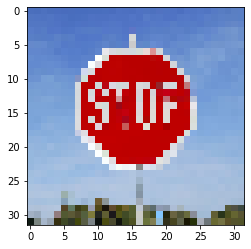

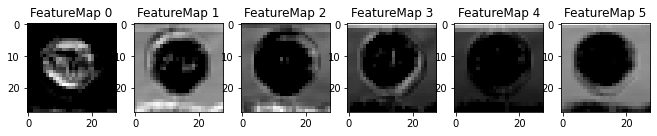

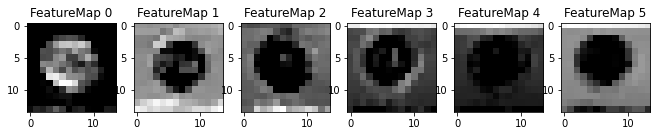

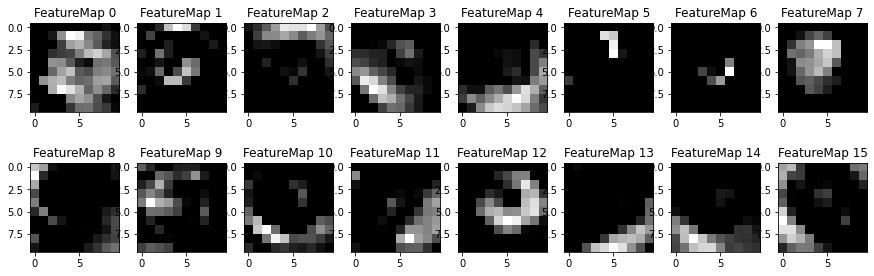

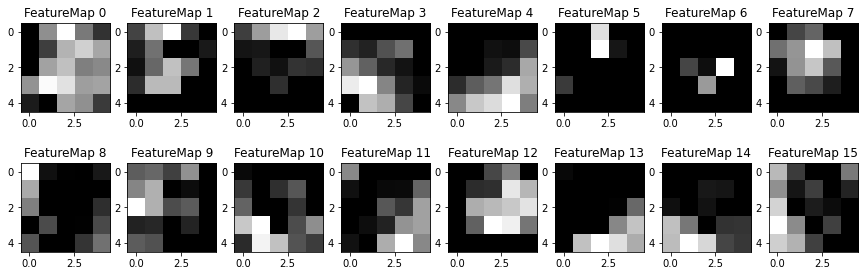

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    image_input   = X_my_test[5]    #The STOP Sign
    
    # Plot Original
    plt.figure(1)#,figsize=(2, 2))             
    plt.imshow(image_input)
    
    # Plot Conv1 after Activation (Relu)
    tf_activation = sess.graph.get_tensor_by_name('conv1:0') #conv2 ,conv1 ,conv2_max ,conv1_max
    outputFeatureMap(image_input, tf_activation, plt_num=2)  #plt_num=2 means figure(2)
    
    # Plot after Max Pool
    tf_activation = sess.graph.get_tensor_by_name('conv1_max:0') 
    outputFeatureMap(image_input, tf_activation, plt_num=3)
    
    # Plot Conv2 after Activation (Relu)
    tf_activation = sess.graph.get_tensor_by_name('conv2:0') 
    outputFeatureMap(image_input, tf_activation, plt_num=4)
    
    # Plot after Max Pool
    tf_activation = sess.graph.get_tensor_by_name('conv2_max:0') 
    outputFeatureMap(image_input, tf_activation, plt_num=5)